In [1]:
import sys
import matplotlib.pyplot as plt
sys.path.append('../')
from synthetic import generate_synthetic, SyntheticGenerator

## Two ways of generating a synthetic seismic: `SyntheticGenerator`-pipeline and `generate_synthetic`-function

* using `SyntheticGenerator`-class and chain of actions

In [2]:
gen = SyntheticGenerator(seed=100)

In [3]:
%%time
gen = (gen.make_velocities(num_reflections=100,
                           horizon_heights=(0.2, 0.3, 0.5, 0.8),
                           horizon_multipliers=(-5, 5, 6, 8))
          .make_velocity_model((200, 800), (10, ))
          .add_faults(faults=(((100, 100), (120, 220)),
                              ((150, 600), (200, 720))),
                      zeros_share=0.4)
          .make_density_model()
          .make_synthetic()
          .postprocess_synthetic(noise_mul=0.2))

CPU times: user 1.15 s, sys: 40.1 ms, total: 1.19 s
Wall time: 1.2 s


Text(0.5, 1.0, 'Velocity model')

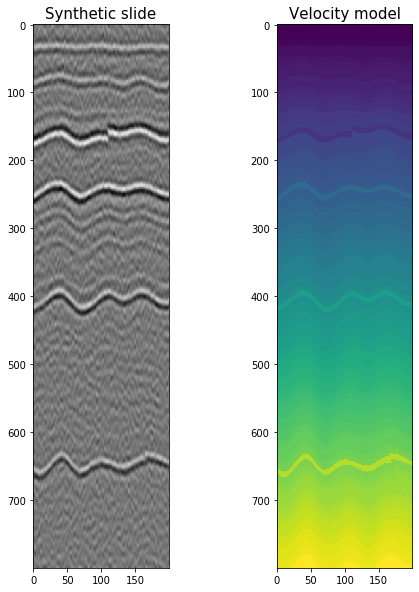

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(8, 10))
ax[0].imshow(gen.synthetic.T, cmap=plt.cm.gray)
ax[0].set_title('Synthetic slide', fontsize=15)
ax[1].imshow(gen.velocity_model.T, cmap=plt.cm.viridis)
ax[1].set_title('Velocity model', fontsize=15)

* using `generate_synthetic`-wrapper

In [5]:
%%time
synt2d, _, _ = generate_synthetic(shape=(200, 800), grid_shape=10, num_reflections=100,
                               horizon_heights=(0.2, 0.3, 0.5, 0.8),
                               horizon_multipliers=(-5, 5, 6, 8),
                               faults=(((100, 100), (120, 220)),
                                       ((150, 600), (180, 720))),
                               zeros_share_faults=0.2, seed=100,
                               noise_mul=0.2,
                              )

CPU times: user 123 ms, sys: 6.19 ms, total: 129 ms
Wall time: 126 ms


Text(0.5, 1.0, 'Synthetic slide')

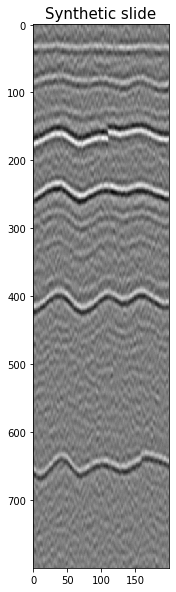

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.imshow(synt2d.T, cmap=plt.cm.gray)
ax.set_title('Synthetic slide', fontsize=15)

## Creating a synthetic cube; `dump` and `load` it with `seismiqb`

In [7]:
sys.path.append('../../../')
from seismiqb.src.geometry.export import make_segy_from_array
from seismiqb.batchflow import Pipeline, Dataset, DatasetIndex, FilesIndex
from seismiqb import Horizon, SeismicGeometry, SeismicCubeset

In [8]:
%%time
synt3d, hors, _ = generate_synthetic(shape=(150, 150, 200), grid_shape=(10, 10),
                                     num_reflections=60, faults=None,
                                     geobodies_format=('heights', 'mask'))

CPU times: user 2.98 s, sys: 112 ms, total: 3.09 s
Wall time: 3.09 s


* dumping created cube

In [9]:
%%time
make_segy_from_array(synt3d, 'cube_test.sgy', zip_segy=False)

/Users/aleksandr/opt/anaconda3/lib/python3.7/site-packages/segyio/utils.py:23: RuntimeWarning: Implicit conversion from float64 to float32 (narrowing)
  warnings.warn(msg.format(x.dtype, dtype), RuntimeWarning)



CPU times: user 1.28 s, sys: 457 ms, total: 1.74 s
Wall time: 1.64 s


* dumping horizons

In [10]:
geom = SeismicGeometry('./cube_test.sgy')

In [11]:
import os
from glob import glob

In [12]:
horizons = [Horizon(hor, geom) for hor in hors]

In [13]:
if not os.path.exists('./test_horizons'):
    os.mkdir('./test_horizons')
for i, horizon in enumerate(horizons):
    horizon.dump('./test_horizons/hor_{}.txt'.format(i))

* using `seismiqb` to load it all

In [14]:
cubes = [
    './cube_test.sgy'
]

dsi = FilesIndex(path=cubes, no_ext=True)
ds = SeismicCubeset(dsi)
ds.load_geometries()

In [15]:
ds.create_labels({ds.indices[0]: glob('./test_horizons/*')})

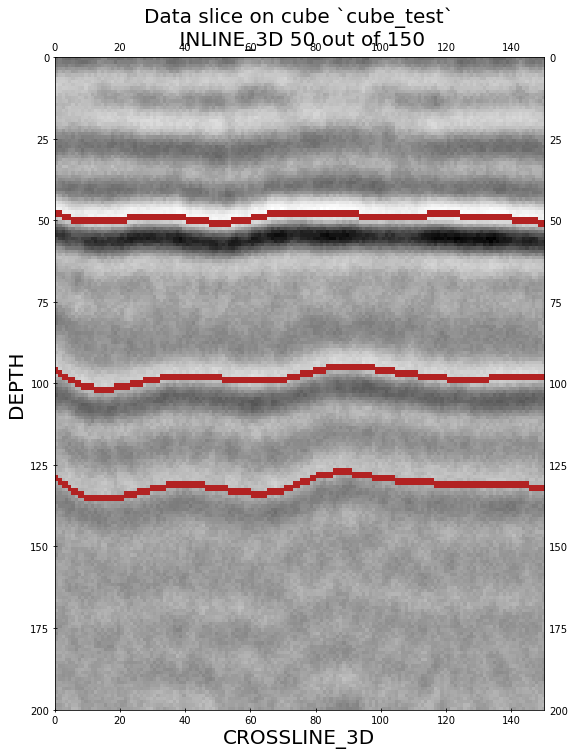

In [17]:
ds.show_slide(50)

* remove everything

In [18]:
import shutil

In [19]:
for path in ['./cube_test.meta', './cube_test.sgy', './test_horizons/', './CUBE_INFO.log']:
    if os.path.exists(path):
        if os.path.isfile(path):
            os.remove(path)
        else:
            shutil.rmtree(path)